# Prior $p(T, F^R, B^R)$

We simulate the bandwidth $p(B^R | F^R, T)$ (just like the LF parameters) using Hawks (1995) to get a joint prior $p(T, F^R, B^R)$, for further downstream processing.

## Joint?

We get a joint prior $p(T, F^R, B^R)$ for the pitch period, the reference formant frequencies F1-F3 and the reference bandwidths B1-B3.

Why joint? Because there are a lot of correlations expected:

- By the uniform scaling hypothesis, $F$ increases as $L$ decreases. Since women generally have higher pitch $F_0=1/T$ and shorter $L$, they generally have higher $F$. So in our case, the correlation between $(T,F)$ encodes basic gender information.
- Bandwidth $B(F)$ is typically higher for females for a given value of $F$, and (Hawks 1995) implement this by linear interpolation using $F_0$. So it is basically the same trick. This is also probably just the same mechanism addressed in the uniform scaling hypothesis.

Below we will see that indeed things are strongly correlated.

In [1]:
%run init.ipy

from vtr.prior import bandwidth
from vtr.prior import formant
from lib import constants
from dgf import bijectors

import corner

2022-11-08 17:13:22.937436: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


[Memory]2.9s, 0.0min    : Loading get_aplawd_training_pairs...


[Memory]17.1s, 0.3min   : Loading run_nested...
[Memory]18.8s, 0.3min   : Loading run_nested...
[Memory]20.3s, 0.3min   : Loading run_nested...
[Memory]21.7s, 0.4min   : Loading run_nested...
[Memory]21.7s, 0.4min   : Loading get_aplawd_training_pairs...


[Memory]25.2s, 0.4min   : Loading get_vtrformants_training_data...
[Memory]32.6s, 0.5min   : Loading run_nested...
[Memory]33.5s, 0.6min   : Loading run_nested...
[Memory]34.4s, 0.6min   : Loading run_nested...
[Memory]35.3s, 0.6min   : Loading run_nested...
[Memory]35.3s, 0.6min   : Loading get_vtrformants_training_data...


## Implement Hawks (1995) $B(F)$ formula



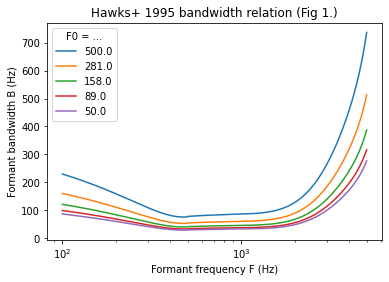

In [2]:
F = np.linspace(100, 5000, 1000)[:,None] # Hz
T = np.logspace(log10(2.), log10(20.), 5)[None,:] # msec

plot(F, bandwidth.hawks_bandwidth(T, F), label=np.round(1000/T).squeeze())
xscale('log')
title("Hawks+ 1995 bandwidth relation (Fig 1.)")
ylabel("Formant bandwidth B (Hz)")
xlabel("Formant frequency F (Hz)")
legend(title="F0 = ...");

## Fit $p(\hat T, F^R)$

**NOTE**: We don't have access to the true $T$ for the TIMIT and VTRFormants databases, so strictly we are making a prior for $p(\hat T, F^R)$, where $\hat T$ stands for Praat's estimate of $T$.
Later we will just replace $\hat T$ by $T$, since Praat is relatively good at estimating $T$ (~7% relative accuracy), and that accuracy will only be better for the vowel events we are considering. On top of that we *average* the $F$ values over the $\hat T$'s so we have an additional error smoothing operation.

In [5]:
bandwidth.TF_prior().sample(seed=jaxkey())

[Memory]141.9s, 2.4min  : Loading get_vtrformants_training_data...
[Memory]142.5s, 2.4min  : Loading run_nested...


DeviceArray([   4.10136518,  551.47398184, 1904.54897361, 2976.27670633],            dtype=float64)

Strong negative correlation between $\hat T$ and $F$ as expected (i.e. strong *positive* correlation between $F_0 = 1/T$ and $F$).

[Memory]150.7s, 2.5min  : Loading get_vtrformants_training_data...
[Memory]151.1s, 2.5min  : Loading run_nested...


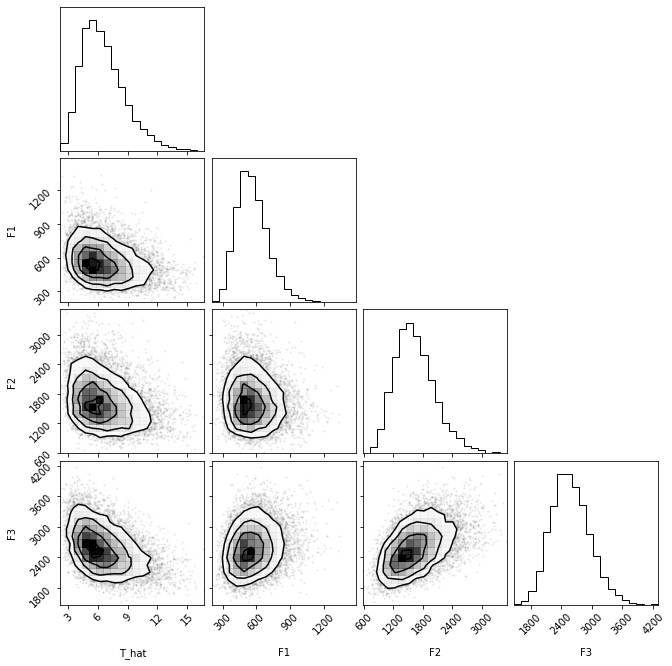

In [6]:
TF_samples = bandwidth.TF_prior().sample(10000, seed=jaxkey())

corner.corner(np.array(TF_samples), labels=bandwidth.TF_NAMES);

## Regress $p(B^R|F^R,\hat T)$ and fit $p(\hat T, F^R, B^R)$!

Just like with LF parameters, regress $B(F,\hat T)$ using Hawks formula and error estimates (given in dB).

Which probability distribution to assign to the errors?

We find ourselves in a textbook Maxent situation. We are only given in Hawks (1995) the expected value of absolute differences in dB. Therefore, our assigned prob distribution is Laplace:

$$p(e = \text{error in dB}) = Laplace(x|\mu=0, b=\text{given error in dB})$$

wehre $\text{given error in dB} = (1.15, 1.9, 3.2) dB$ depending on whether we are regressing $F_1(B_1, \hat T)$, $F_2(B_2, \hat T)$ or $F_3(B_3, \hat T)$.

In [7]:
bandwidth.HAWKS_ERRORS_DB

(1.15, 1.9, 3.2)

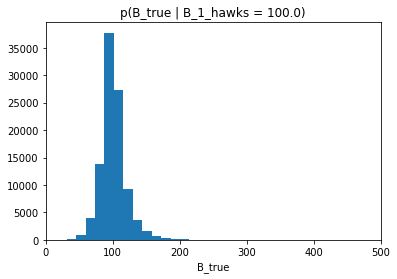

In [8]:
import scipy.stats

B_hawks = 100.
error_db = bandwidth.HAWKS_ERRORS_DB[0]

factor = 10**(scipy.stats.laplace(scale=error_db).rvs(100000)/20)*B_hawks
hist(factor, bins=50)
xlim(0, 500)
title(f"p(B_true | B_1_hawks = {B_hawks})")
xlabel("B_true");

In [44]:
TFB = bandwidth.sample_TFB()

[Memory]727.9s, 12.1min : Loading get_vtrformants_training_data...
[Memory]728.3s, 12.1min : Loading run_nested...


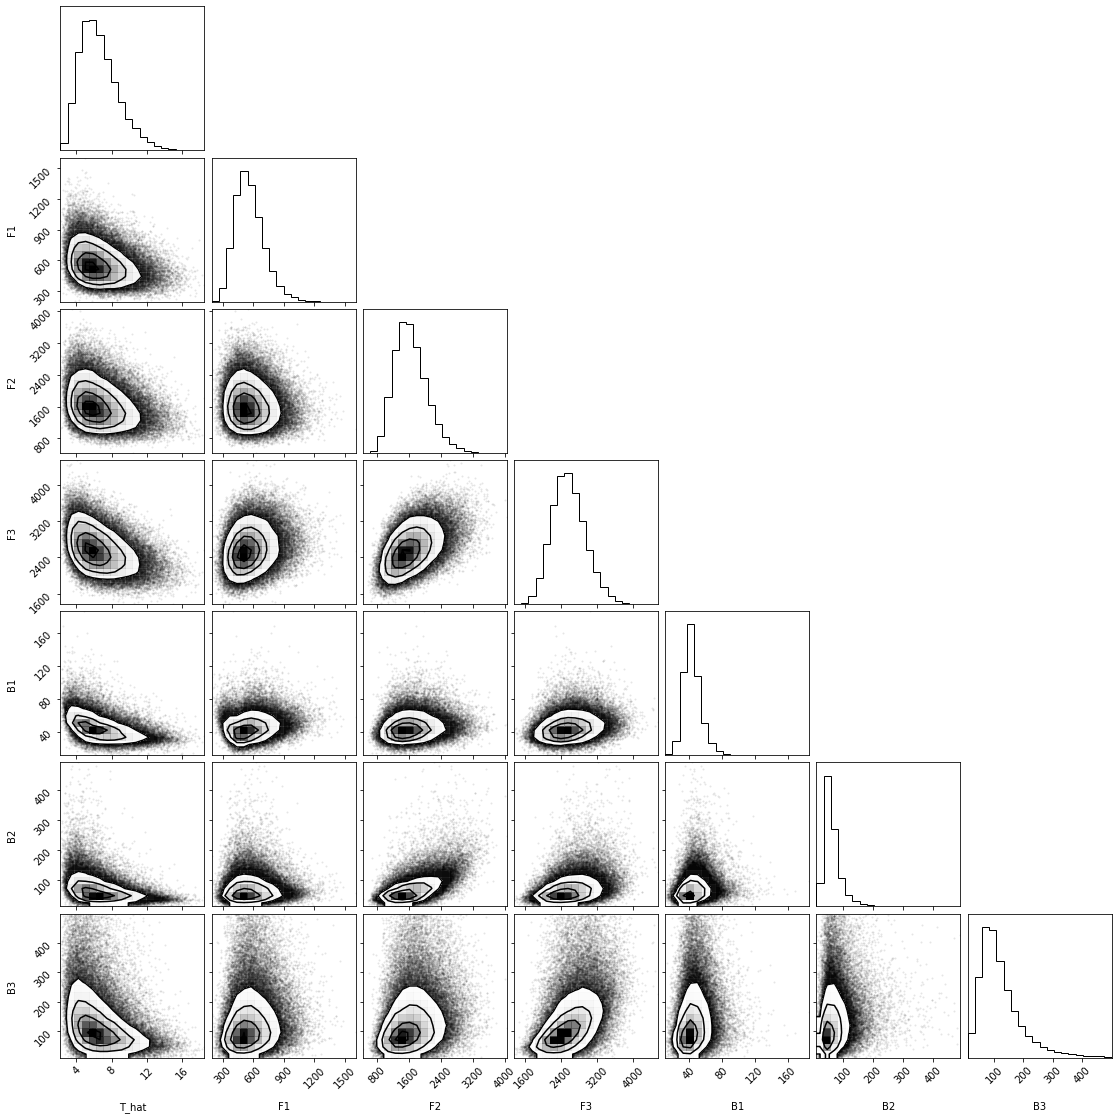

In [56]:
import corner

corner.corner(TFB, labels=bandwidth.TFB_NAMES);

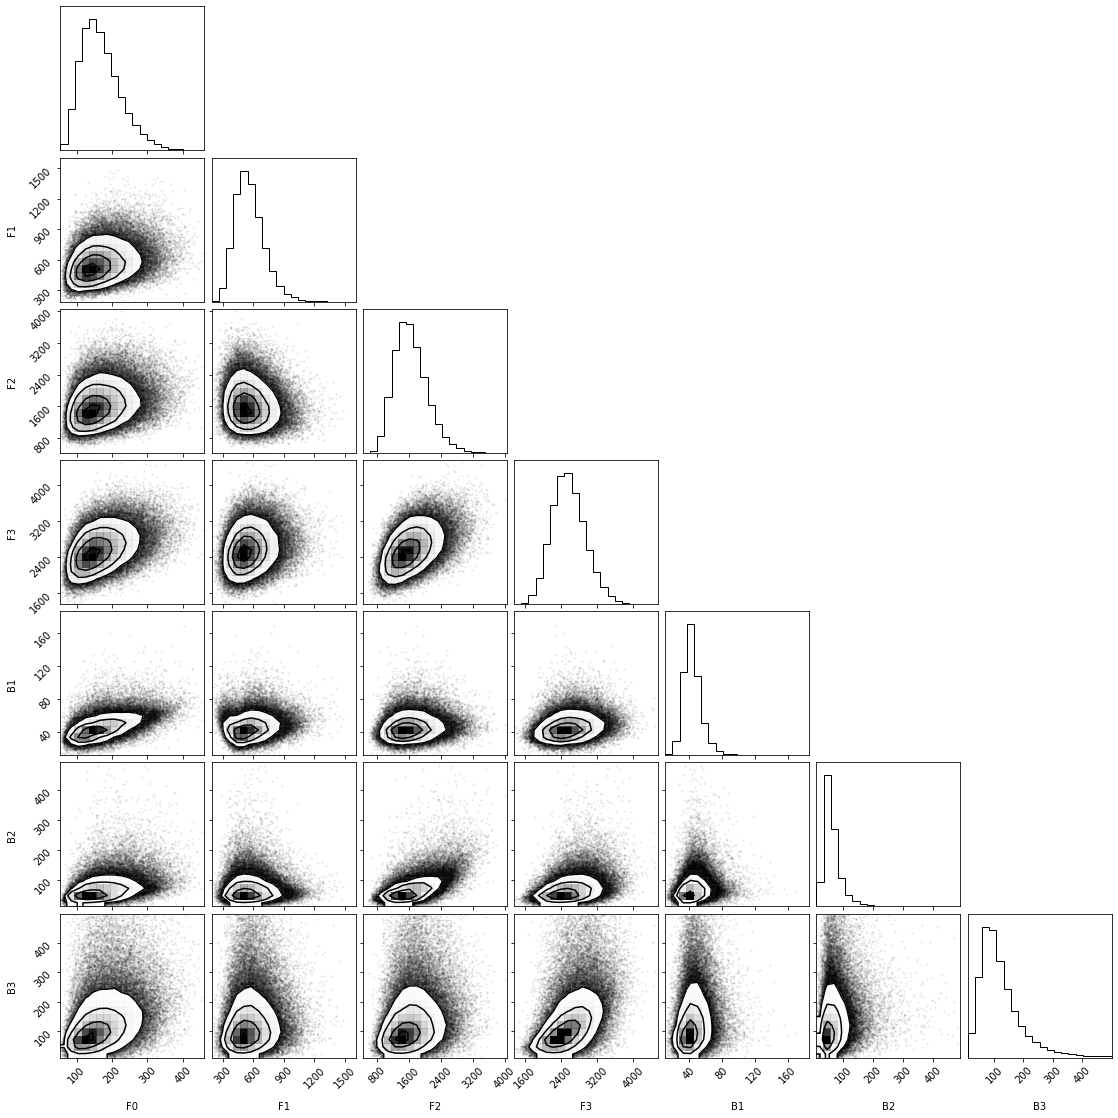

In [46]:
# Look at correlations with F0 instead of T
FFB = np.column_stack((1000/TFB[:,0],TFB[:,1:]))

corner.corner(FFB, labels=("F0", "F1", "F2", "F3", "B1", "B2", "B3"));

## Fit prior $p(T, F, B)$

In [48]:
%%time
# It works in O(10) min
bb, results = bijectors.fit_nonlinear_coloring_bijector(
    TFB, bandwidth.TFB_BOUNDS, 3325495, return_fit_results=True
)

________________________________________________________________________________
[Memory] Calling dgf.bijectors.run_nested...
run_nested(3325495, {'nlive': 35}, {'save_bounds': False})


1602it [12:25,  2.15it/s, +35 | bound: 853 | nc: 1 | ncall: 54367 | eff(%):  3.013 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-  1.048 | dlogz:  0.001 >  0.044]

____________________________________________________run_nested - 749.4s, 12.5min
CPU times: user 27min 20s, sys: 1min 27s, total: 28min 47s
Wall time: 12min 29s


Summary
nlive: 35
niter: 1602
ncall: 54332
eff(%):  3.013
logz: -3567732.434 +/-  1.094


None

'Information (bans)'

16.860561844078614

Quantiles:
$x_{1}$ [(0.025, 1.1045921978297977), (0.5, 1.1083449607208413), (0.975, 1.1133636072154616)]
Quantiles:
$x_{2}$ [(0.025, 0.9988998378630977), (0.5, 1.002427956443456), (0.975, 1.0064761210212847)]
Quantiles:
$x_{3}$ [(0.025, 1.0154329543949037), (0.5, 1.0191872915296496), (0.975, 1.0229306161120555)]
Quantiles:
$x_{4}$ [(0.025, 1.016563178476211), (0.5, 1.0205918417187005), (0.975, 1.0236422378439844)]
Quantiles:
$x_{5}$ [(0.025, 1.001762160751974), (0.5, 1.005696454087159), (0.975, 1.0096158986562813)]
Quantiles:
$x_{6}$ [(0.025, 1.0478557719459742), (0.5, 1.0510421189263608), (0.975, 1.0549675063665025)]
Quantiles:
$x_{7}$ [(0.025, 1.2179118443506394), (0.5, 1.2222542391681623), (0.975, 1.2271621189378568)]


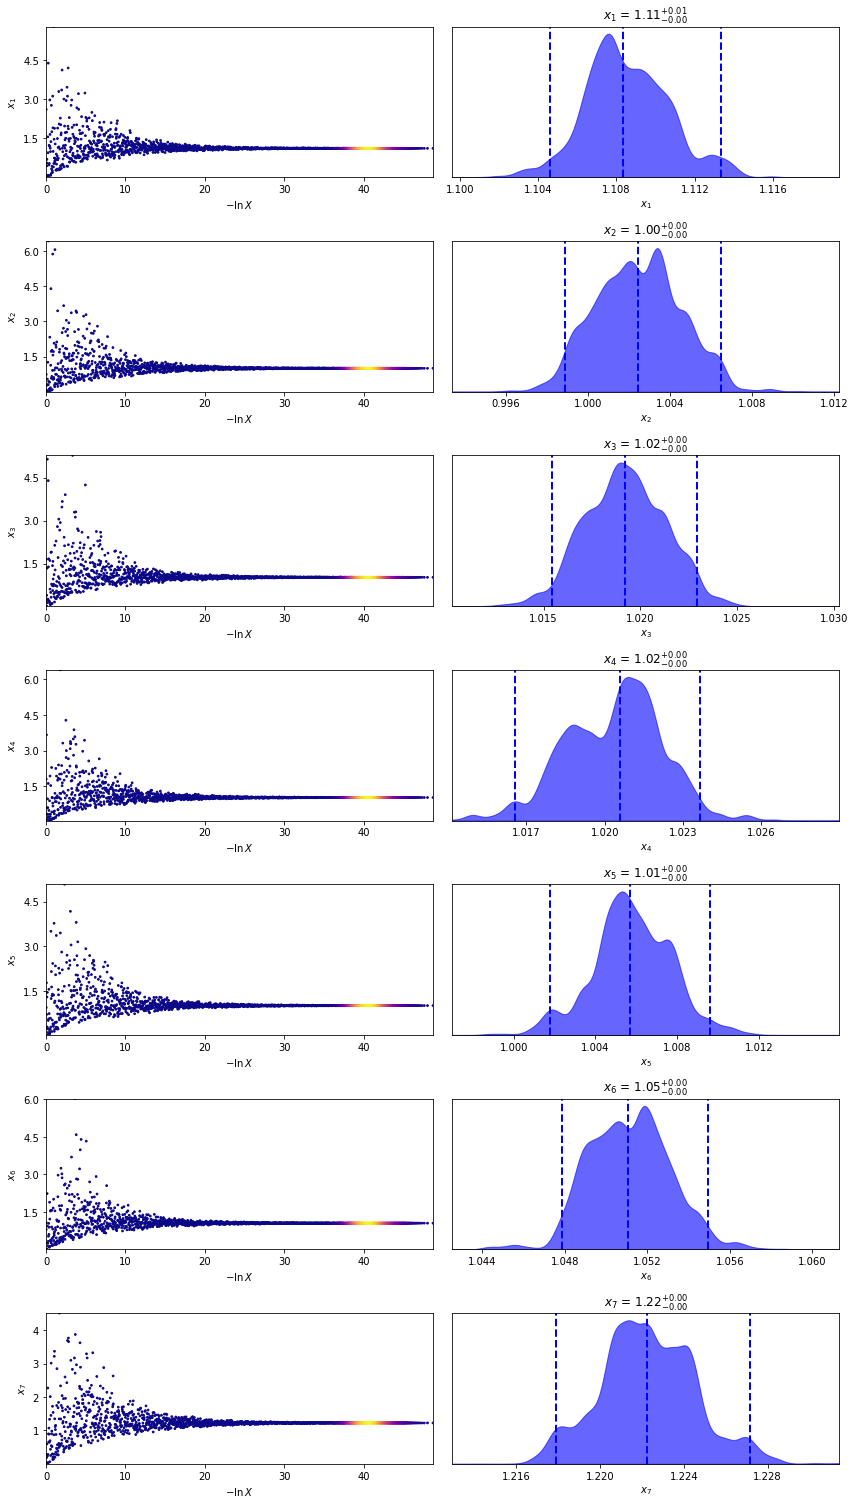

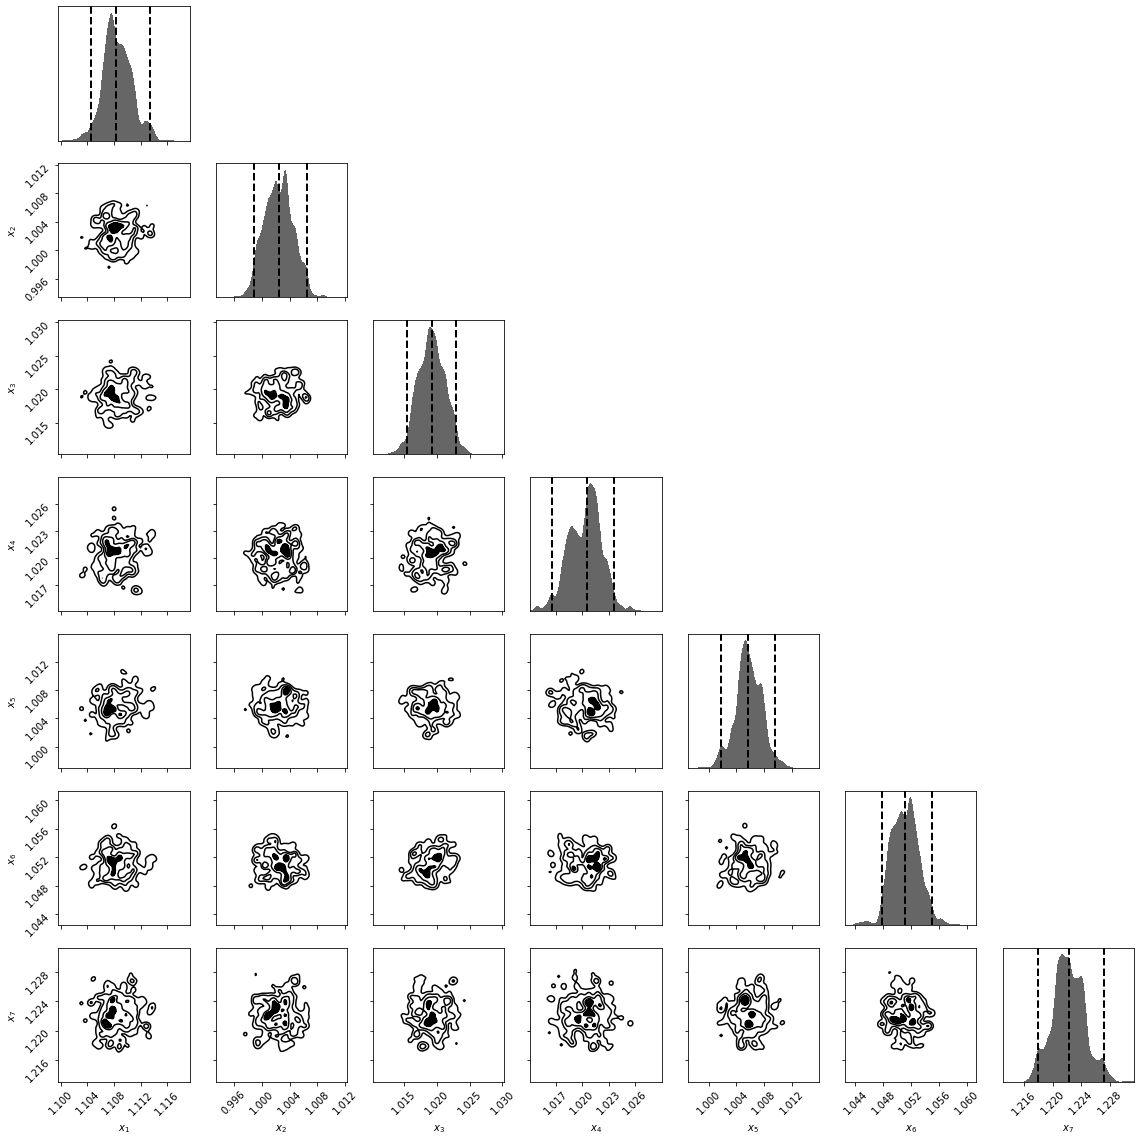

In [49]:
from lib import util
util.dyplot(results)

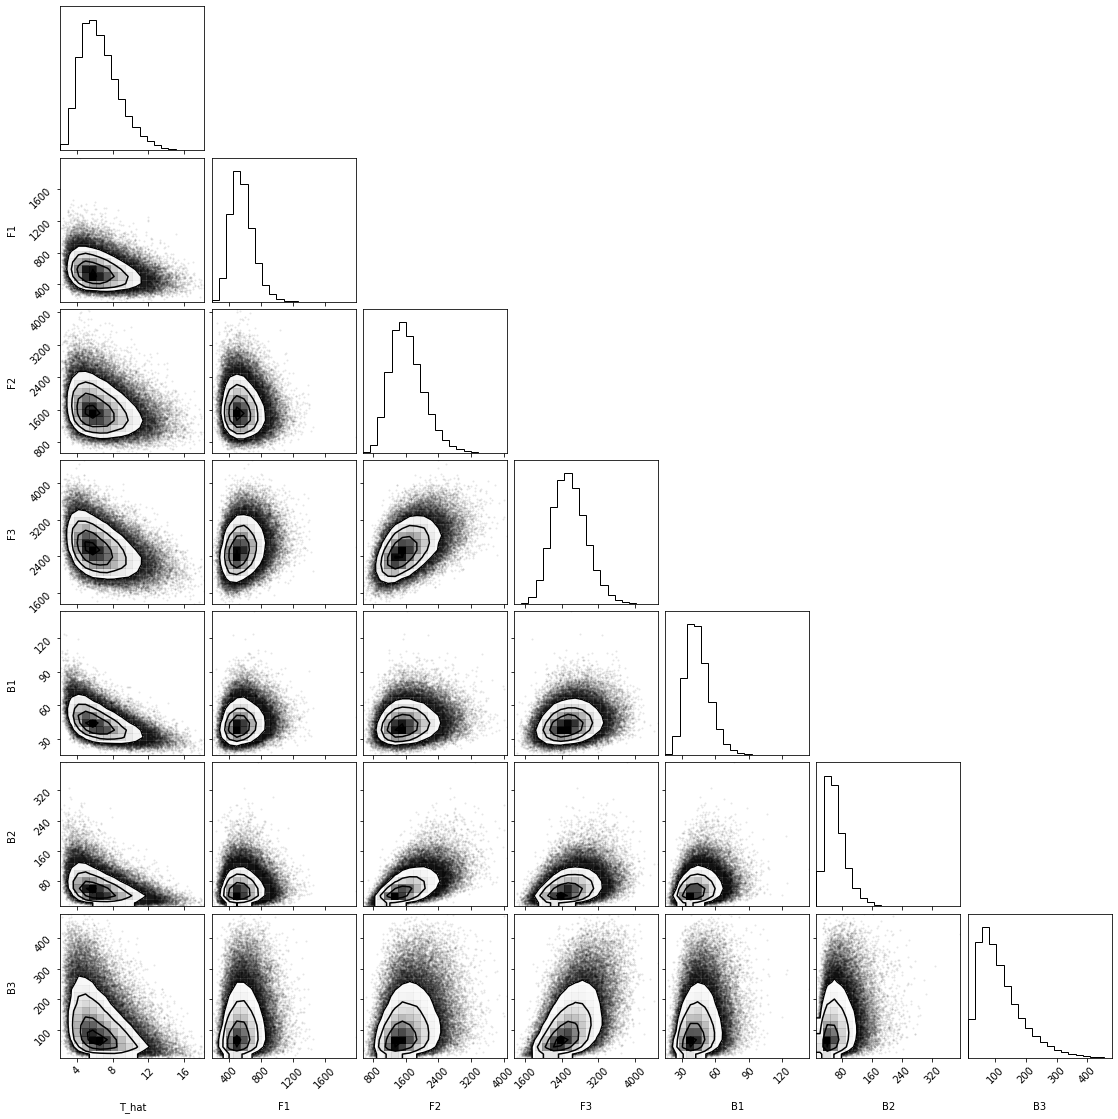

In [57]:
samples = prior.sample(100000, seed=jaxkey())

corner.corner(np.array(samples), labels=bandwidth.TFB_NAMES);

All good!

## Overlay on Hawks plot

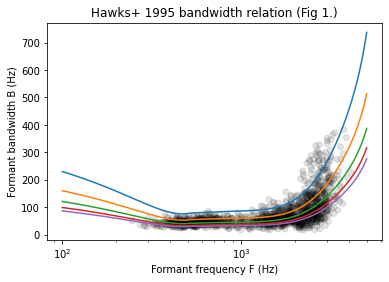

In [59]:
def sample_point():
    pt = prior.sample(seed=jaxkey())
    T = pt[0]
    F = pt[1:4]
    B = pt[4:]
    return T, F, B

for _ in range(500):
    T, F, B = sample_point()
    scatter(F, B, c=np.repeat(T,3), cmap='gray', alpha=.1)

F = np.linspace(100, 5000, 1000)[:,None] # Hz
T = np.logspace(log10(2.), log10(20.), 5)[None,:] # msec

plot(F, bandwidth.hawks_bandwidth(T, F))
xscale('log')
title("Hawks+ 1995 bandwidth relation (Fig 1.)")
ylabel("Formant bandwidth B (Hz)")
xlabel("Formant frequency F (Hz)");

## Convolbve!

Use the F and B as poles à la Klatt

In [79]:
num_pitch_periods = 1000

### Source signal

In [80]:
from dgf.prior import lf

envelope_kernel_name = 'Matern32Kernel'
envelope_lengthscale = 100.

prior = lf.generic_params_trajectory_prior(
    num_pitch_periods,
    envelope_kernel_name,
    envelope_lengthscale,
    envelope_noise_sigma = 0. # Setting this to 0. is crucial, otherwise
)                             # very breathy sound

t, u, log_prob_u, context = lf.sample_and_log_prob_dgf(
    prior, jaxkey(1111), num_pitch_periods, return_full=True,
    noise_floor_power=0. # Causes Non-finite log likelihood, otherwise doesnt
)                        # affect sound

[Memory]2276.7s, 37.9min: Loading sample_lf_params...
[Memory]2276.7s, 37.9min: Loading run_nested...


/home/marnix/WRK/thesis/py/dgf/prior/lf.py:493: UserWarning: Non-finite log likelihood at period indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200

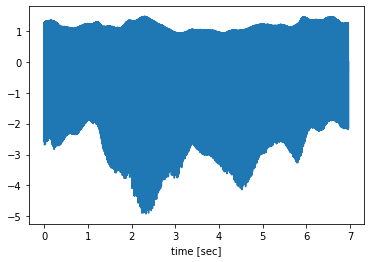

In [81]:
plot(t/1000, u)
xlabel("time [sec]");

from lib import klatt
klatt.play(t, u)

### Filter signal (this notebook)

In [82]:
kernel_name, _b, results = formant.fit_formants_trajectory_kernel()
lengthscale, noise_sigma = formant.maximum_likelihood_envelope_params(results)
lengthscale, noise_sigma

(15.239198437183395, 0.00881657240832212)

In [83]:
bbt = bijectors.nonlinear_coloring_trajectory_bijector(
    bandwidth.TFB_prior().bijector,
    num_pitch_periods,
    kernel_name,
    lengthscale,
    noise_sigma
)

[Memory]2321.7s, 38.7min: Loading get_vtrformants_training_data...
[Memory]2322.1s, 38.7min: Loading run_nested...
[Memory]2322.3s, 38.7min: Loading run_nested...


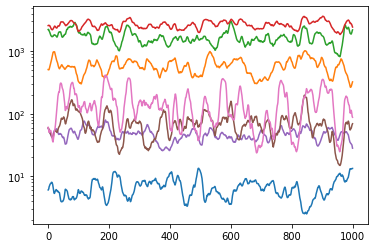

In [84]:
TFB = bbt.forward(randn(7*num_pitch_periods))

plot(TFB)
yscale('log');

In [85]:
F = TFB[:,1:4]
B = TFB[:,4:]

### Convolve

In [86]:
import scipy.signal
from dgf import core

from dgf.prior import source

def support(t, T0, offset=0., pre=0, post=1):
    i = lf._nonzero_dgf_indices(t - offset, T0)
    a = max(i[0] - len(i)*pre, 0)
    b = min(i[0] + len(i)*(1+post), len(t))
    return a, b

def convolve(i, ui, Fi, Bi, t, p, start, end):
    """This can be made JAX-compatible with `jax.scipy.linalg.expm()`, as `lsim()` uses `expm()`"""
    # For a real speedup maybe use `scipy.signal.cont2discrete()` and then just `jax.convolve`
    a, b = support(
        t, p['T0'][i], offset=t[start],
        pre=0, post=10 # You need 10 if you really want to capture everything
    )
    ut = np.zeros_like(t)
    ut[start:end] = ui
    uu = ut[a:b]
    tt = t[a:b]
    
    q = core.make_poles(Bi, Fi)

    zeros = np.array([])
    poles = np.hstack([q, np.conj(q)])
    gain = np.prod(np.abs(q)**2)

    print(i, end=" ")
    T, y, _ = scipy.signal.lsim((zeros, poles, gain), uu, tt)
    out = np.zeros_like(t)
    out[a:b] = y
    return out

p = context['p']
us = context['us']
t = np.array(t)
start, end = context['start'], context['end']

conv = np.array([convolve(i, ui, Fi, Bi, t, p, start[i], end[i]) for i, (Fi, Bi, ui) in enumerate(zip(F, B, us))])
out = np.nansum(conv, axis=0)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

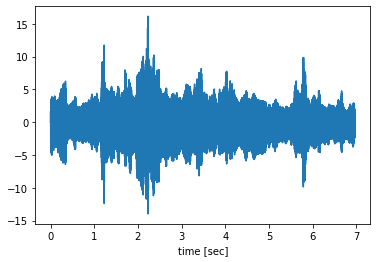

In [87]:
plot(t/1000, out)
xlabel("time [sec]");

In [88]:
klatt.play(t, out)

(0.0, 4000.0)

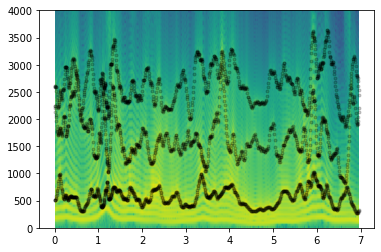

In [89]:
fs = constants.FS_KHZ
specgram(out, Fs=fs*1000);
plot((start + end)/2/(fs*1000), F, '.', c="black", alpha=.2)
ylim(None, 4000)

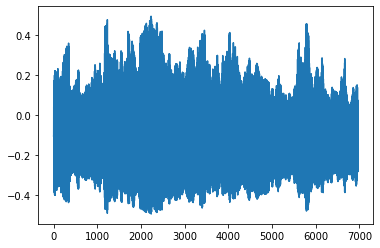

In [90]:
def compress(a, factor=.85):
    from scipy.special import expit
    m, s = np.mean(a), np.std(a)
    x = (a - m)/s
    return expit((x - 0.5)*factor) - 0.5
        
plot(t, compress(out))
klatt.play(t, compress(out))